<a href="https://colab.research.google.com/github/zamirsiddiqui/summarization/blob/master/summarizationFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import numpy as np
import nltk
from nltk.corpus import stopwords #provides list of english stopwords
from bs4 import BeautifulSoup
import re
import httpimport

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [0]:
from attention import AttentionLayer

In [80]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Read files from github
url = 'https://media.githubusercontent.com/media/zamirsiddiqui/summarization/master/train.article.txt'
train_article = pd.read_table(url, error_bad_lines=False, header = None)

In [82]:
pd.set_option('display.max_colwidth', -1)
train_article.head()

,0
0,"australia 's current account deficit shrunk by a record #.## billion dollars -lrb- #.## billion us -rrb- in the june quarter due to soaring commodity prices , figures released monday showed ."
1,"at least two people were killed in a suspected bomb attack on a passenger bus in the strife-torn southern philippines on monday , the military said ."
2,"australian shares closed down #.# percent monday following a weak lead from the united states and lower commodity prices , dealers said ."
3,south korea 's nuclear envoy kim sook urged north korea monday to restart work to disable its nuclear plants and stop its `` typical '' brinkmanship in negotiations .
4,"south korea on monday announced sweeping tax reforms , including income and corporate tax cuts to boost growth by stimulating sluggish private consumption and business investment ."


In [83]:
url = 'https://media.githubusercontent.com/media/zamirsiddiqui/summarization/master/train.title.txt'
train_title = pd.read_table(url, error_bad_lines=False, header = None)
#pd.set_option('display.max_colwidth', -1)
train_title.head()

,0
0,australian current account deficit narrows sharply
1,at least two dead in southern philippines blast
2,australian stocks close down #.# percent
3,envoy urges north korea to restart nuclear disablement
4,skorea announces tax cuts to stimulate economy


In [84]:
train_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
0    10000 non-null object
dtypes: object(1)
memory usage: 78.2+ KB


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [0]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
#call the function
cleaned_text = []
for t in train_article[0]:
    cleaned_text.append(text_cleaner(t,0))

In [88]:
cleaned_text[:5]

['australia current account deficit shrunk record billion dollars lrb billion us rrb june quarter due soaring commodity prices figures released monday showed',
 'least two people killed suspected bomb attack passenger bus strife torn southern philippines monday military said',
 'australian shares closed percent monday following weak lead united states lower commodity prices dealers said',
 'south korea nuclear envoy kim sook urged north korea monday restart work disable nuclear plants stop typical brinkmanship negotiations',
 'south korea monday announced sweeping tax reforms including income corporate tax cuts boost growth stimulating sluggish private consumption business investment']

In [89]:
#call the function
cleaned_summary = []
for t in train_title[0]:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:5]

['australian current account deficit narrows sharply',
 'at least two dead in southern philippines blast',
 'australian stocks close down percent',
 'envoy urges north korea to restart nuclear disablement',
 'skorea announces tax cuts to stimulate economy']

In [0]:
data = pd.DataFrame()
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [91]:
data.head()

,cleaned_text,cleaned_summary
0,australia current account deficit shrunk record billion dollars lrb billion us rrb june quarter due soaring commodity prices figures released monday showed,australian current account deficit narrows sharply
1,least two people killed suspected bomb attack passenger bus strife torn southern philippines monday military said,at least two dead in southern philippines blast
2,australian shares closed percent monday following weak lead united states lower commodity prices dealers said,australian stocks close down percent
3,south korea nuclear envoy kim sook urged north korea monday restart work disable nuclear plants stop typical brinkmanship negotiations,envoy urges north korea to restart nuclear disablement
4,south korea monday announced sweeping tax reforms including income corporate tax cuts boost growth stimulating sluggish private consumption business investment,skorea announces tax cuts to stimulate economy


In [0]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [0]:
max_text_len=50
max_summary_len=12

In [0]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [0]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [96]:
df.head()

,text,summary
0,australia current account deficit shrunk record billion dollars lrb billion us rrb june quarter due soaring commodity prices figures released monday showed,sostok australian current account deficit narrows sharply eostok
1,least two people killed suspected bomb attack passenger bus strife torn southern philippines monday military said,sostok at least two dead in southern philippines blast eostok
2,australian shares closed percent monday following weak lead united states lower commodity prices dealers said,sostok australian stocks close down percent eostok
3,south korea nuclear envoy kim sook urged north korea monday restart work disable nuclear plants stop typical brinkmanship negotiations,sostok envoy urges north korea to restart nuclear disablement eostok
4,south korea monday announced sweeping tax reforms including income corporate tax cuts boost growth stimulating sluggish private consumption business investment,sostok skorea announces tax cuts to stimulate economy eostok


In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [99]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 53.57066874689739
Total Coverage of rare words: 5.693634962532552


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [101]:
x_voc

6548

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [103]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.30543099152965
Total Coverage of rare words: 9.500503644012563


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [105]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(8981, 8981)

In [0]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [109]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:107: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:111: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      654800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [113]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8975 samples, validate on 997 samples
Epoch 1/50
8975/8975 [==============================] - 323s 36ms/sample - loss: 4.6145 - val_loss: 3.9901
Epoch 2/50
8975/8975 [==============================] - 316s 35ms/sample - loss: 4.0457 - val_loss: 3.7490
Epoch 3/50
8975/8975 [==============================] - 348s 39ms/sample - loss: 3.8244 - val_loss: 3.6837
Epoch 4/50
8975/8975 [==============================] - 324s 36ms/sample - loss: 3.6867 - val_loss: 3.5579
Epoch 5/50
8975/8975 [==============================] - 353s 39ms/sample - loss: 3.5838 - val_loss: 3.4758
Epoch 6/50
8975/8975 [==============================] - 317s 35ms/sample - loss: 3.4952 - val_loss: 3.4367
Epoch 7/50
8975/8975 [==============================] - 319s 36ms/sample - loss: 3.4061 - val_loss: 3.3629
Epoch 8/50
8975/8975 [==============================] - 324s 36ms/sample - loss: 3.3125 - val_loss: 3.3127
Epoch 9/50
8975/8975 [==============================] - 321s 36ms/sample - loss: 3.2232 - val_los

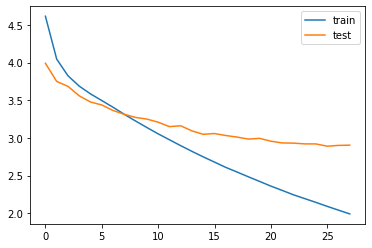

In [114]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
history.model.save('model.h5')

In [0]:
from numpy import loadtxt
from keras.models import load_model


In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [135]:
for i in range(5,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: us president george bush tuesday endorsed federal reserve rescue loan troubled insurance giant american insurance group move would promote stability financial markets white house said statement 
Original summary: bush backs fed rescue of troubled insurer aig 
Predicted summary:  bush vows to save rescue rescue deal


Review: french court tuesday convicted iranian murdering former iranian prime minister shahpur bakhtiar sentenced life prison trial tehran government dock 
Original summary: french court iranian for life in bakhtiar killing 
Predicted summary:  spanish court jails mother of life sentence for killing


Review: alitalia trade unions warned wednesday less hours accept deal rescue plan ailing airline ansa news agency reported 
Original summary: alitalia unions given deadline to accept takeover proposals 
Predicted summary:  german leaders says key phase of financial crisis


Review: trial opened ivory coast monday people charged involvement toxic waste scandal killed i

In [0]:
result = pd.DataFrame({'Article': [], 'Actual Summary': [], 'Pridicted Summary': []})
for i in range(5,100):
    result = result.append({'Article': seq2text(x_tr[i]), 'Actual Summary': seq2summary(y_tr[i]), 'Pridicted Summary': decode_sequence(x_tr[i].reshape(1,max_text_len))}, ignore_index=True)

In [0]:
result.to_csv("Result.csv", index=False)